In [62]:
import sys
import os
import glob
from mpi4py import MPI
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format = 'png'
import scripts.statistics as stats
import scripts.get_namelist as nml
from scripts.common import *

def get_means(directory,tID):
    dat = np.fromfile( directory + 'shearlayer_means_%04d'%(tID)+'.dat',dtype=float, count=-1, sep=' ')
    dat = np.reshape(dat,[Ny,6])
    rbar = dat[:,0]
    ubar = dat[:,1]*-1 # normalize ubar from 0 to 1
    vbar = dat[:,2]
    wbar = dat[:,3]
    pbar = dat[:,4]
    Tbar = dat[:,5]
    return rbar,ubar,vbar,wbar,pbar,Tbar
def plot_crocco(flist):
    factors = np.zeros(len(flist))
    fig,ax = plt.subplots(1,2,figsize=(10,3.5),dpi=100)
    
    for count,fname in enumerate(flist):
        tID = fname.split('_')[-1]
        tID = int(tID.split('.dat')[0])
        time = nml.read_time(directory,tID)
        
        # Get eta
        dtheta = get_dtheta(directory,time)
        eta = y/dtheta
        
        rbar,ubar,vbar,wbar,pbar,Tbar = get_means(directory,tID)
        Tbar = pbar/rbar
        ubar = (ubar*inp.du) - inp.du/2

        T1 = Tbar[0]
        T2 = Tbar[-1]
        uinf = inp.du/2.
        C1 = (T1-T2)/(2.*uinf)
        C2 = (T1+T2)/2. + (uinf)**2/2.
        T = -0.5*ubar**2 + C1*ubar + C2 
    
        ax[0].plot(eta,Tbar-T2,alpha=0.5)
        ax[0].plot(eta,T-T2,'k:',alpha=0.5)
        
        
        idx = np.argmax(T-T1)
        factors[count] = (T[idx]-T1)/(Tbar[idx]-T1)


    ax[0].set_xlim([-20,20])
    ax[0].legend([r'$\bar{T}$',r'$\bar{T}_{CB}$'])
    ax[0].set_xlabel(r'$\eta$')
    ax[0].grid(True)
    ax[1].grid(True)
    ax[1].plot(factors,'k-o')
    ax[1].set_xlabel('t')
    #ax[1].set_title(r'$\beta$')

    return factors

In [63]:
directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc12/rr1/1024x1448x512/'


inp = nml.inputs(directory,verbose=True)
Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=True)
Ny = int(Ny)
y = np.linspace(Ly/2.,-Ly/2.,Ny)

flist = glob.glob(directory+"*means*")
flist.sort()
print([f.split('/')[-1] for f in flist])

Params for this run:
	Mc = 1.2
	Re = 1000.0
	rr = 1.0
Params for this grid:
	N = 1024x1448x512
	L = 100.0x100.0x50.0
['shearlayer_means_0004.dat', 'shearlayer_means_0005.dat', 'shearlayer_means_0006.dat', 'shearlayer_means_0007.dat', 'shearlayer_means_0008.dat', 'shearlayer_means_0009.dat']


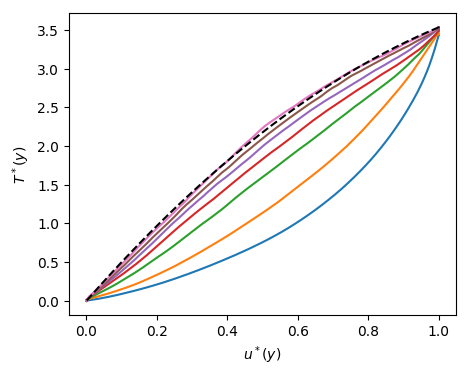

In [70]:
# plot normalized u,T
def plot_quadratic_T(directory,flist,savename=None):
    fig = plt.figure(figsize=(5,4),dpi=100)

    for count,fname in enumerate(flist):
            tID = fname.split('_')[-1]
            tID = int(tID.split('.dat')[0])
            time = nml.read_time(directory,tID)

            rbar,ubar,vbar,wbar,pbar,Tbar = get_means(directory,tID)
            Tbar = pbar/rbar
            ubar = (ubar*inp.du) - inp.du/2


            T1 = Tbar[0]
            T2 = Tbar[-1]
            u1 = ubar[0]
            u2 = ubar[-1]
            Tbar = (Tbar-T2)#/(T1-T2)
            ubar = (ubar-u2)/(u1-u2)

            plt.plot(ubar,Tbar,label='t = %0.3f'%time)

    #plt.legend()

    # fit a line through the data:
    p = np.polyfit(ubar, Tbar, 2)
    fit = p[0]*ubar**2 + p[1]*ubar + p[2]

    plt.plot(ubar,fit,'k--')
    plt.ylabel('$T^*(y)$')
    plt.xlabel('$u^*(y)$')
    
    if savename:
        fig.savefig(directory+'/img/quadratic_T.png',dpi=200,bbox_inches='tight')
        print "Saved plot to ",savename
    else: fig.show()
    return p

p=plot_quadratic_T(directory,flist)#,savename=directory+'/img/quadratic_T.png')

Saved plot to  /projects/ShockInducedMix/ShearLayerData/production/Mc02/rr7/1024x1448x512//img/quadratic_T.png
Saved plot to  /projects/ShockInducedMix/ShearLayerData/production/Mc08/rr7/1024x1448x512//img/quadratic_T.png
Saved plot to  /projects/ShockInducedMix/ShearLayerData/production/Mc20/rr7/1024x1448x512//img/quadratic_T.png
Done


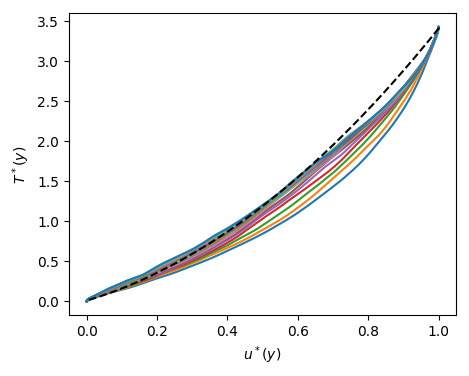

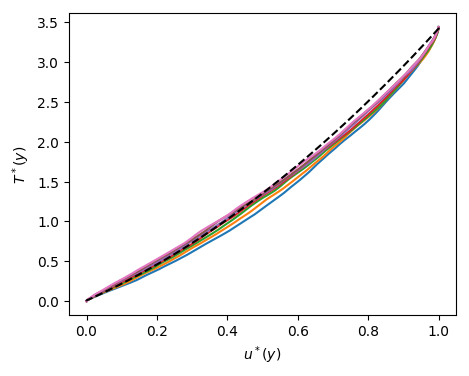

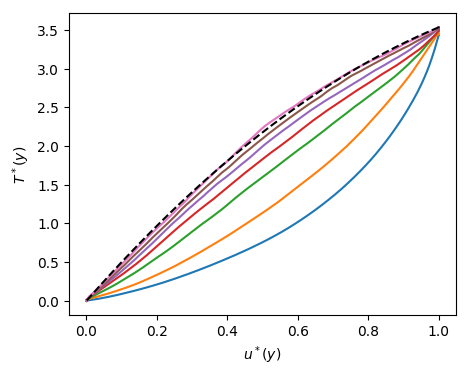

In [73]:
s = '7'

if s=='1': Mc_list = ['02','04','08','12','16','20']
else: Mc_list = ['02','08','20']

for Mc in Mc_list:
    directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc%s/rr%s/1024x1448x512/'%(Mc,s)
    inp = nml.inputs(directory,verbose=False)
    Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=False)
    Ny = int(Ny)
    y = np.linspace(-Ly/2.,Ly/2.,Ny)

    flist = glob.glob(directory+"*means*")
    flist.sort()
    
    p=plot_quadratic_T(directory,flist,savename=directory+'/img/quadratic_T.png')

print('Done')

Mean, std: [1.00046378505, 0.00016955243998]
(0.2, 0.142858)


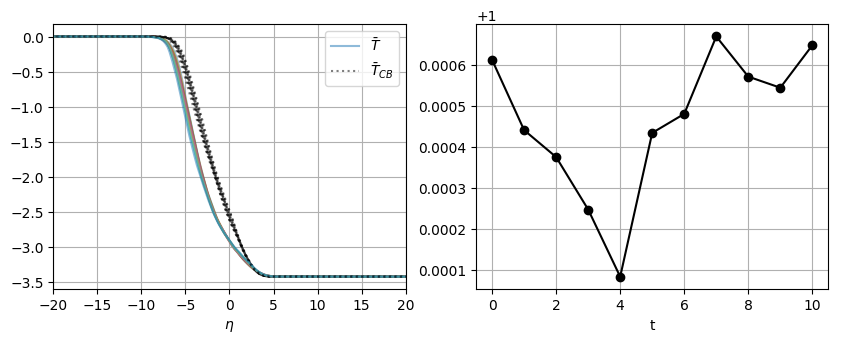

In [186]:
# Quadratic relation between temperature and velocity:

factors = plot_crocco(flist[:])

i = 0
print("Mean, std: [{}, {}]".format(np.mean(factors[i:]),np.std(factors[i:])))

print(inp.Mc,inp.rr)
plt.savefig(directory+'/img/crocco_busemann.png',dpi=200,bbox_inches='tight')

/gpfs/mira-home/kmatsuno/floatpy_env/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


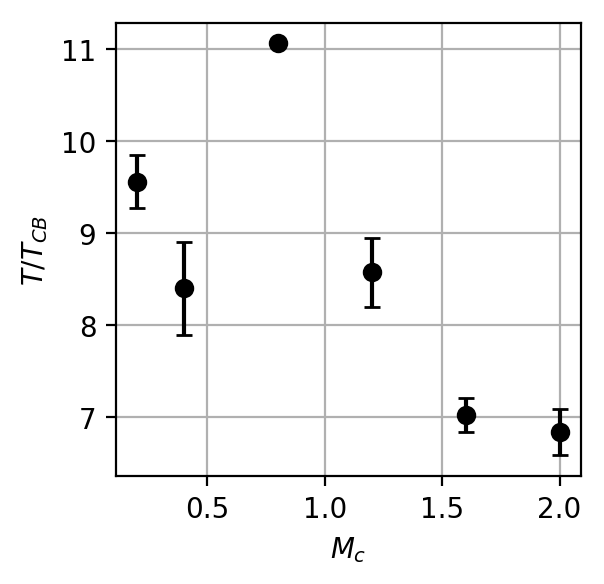

In [190]:
# plot factor vs Mc:
beta = {
    0.2: [9.55736687356, 0.287505933002],
    0.4: [8.40304391943, 0.506574351588],
    0.8: [11.0628131329, 0.0],
    1.2: [8.5778695112, 0.375168608469],
    1.6: [7.0284832565, 0.186050186828],
    2.0: [6.83960899703, 0.247710264379]}

fig = plt.figure(figsize=(3,3),dpi=200)
d = beta
plt.errorbar(d.keys(),[x[0] for x in d.values()], yerr=[x[1] for x in d.values()],fmt='ko',label='s=1',capsize=3)
plt.xlabel('$M_c$')
plt.ylabel('$T/T_{CB}$')
plt.grid('True')